<a href="https://colab.research.google.com/github/Aleksandr62aa/YOLOv8_Tracking/blob/main/FC_NN_class_MNIST_train_loader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Classification of handwritten numbers by a fully connected neural network**

**Dataset MNIST**

**Importing libraries**

In [1]:
import torch
import random
import numpy as np
import torchvision.datasets
from torch.utils.data import DataLoader, Dataset
import cv2
from tqdm import tqdm

# Fixed seed
random.seed(7)
np.random.seed(7)
torch.manual_seed(7)
torch.cuda.manual_seed(7)
torch.backends.cudnn.deterministic = True

In [2]:
# Hyperparameters
batch_size = 100
num_epochs = 100
learning_rate = 1.0e-3

**Train Test dataset**

In [3]:
class DatasetTrain(Dataset):
    def __init__(self):
        self.MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
        self.X_train = self.MNIST_train.train_data
        self.y_train = self.MNIST_train.train_labels
        self.X_train = self.X_train.float()/255
        self.X_train = self.X_train.reshape([-1, 28 * 28])

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, index):
        return self.X_train[index], self.y_train[index]

In [4]:
class DatasetTest(Dataset):
    def __init__(self):
        self.MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)
        self.X_test = self.MNIST_test.test_data
        self.y_test = self.MNIST_test.test_labels
        self.X_test = self.X_test.float()/255
        self.X_test = self.X_test.reshape([-1, 28 * 28])

    def __len__(self):
        return len(self.X_test)

    def __getitem__(self, index):
        return self.X_test[index], self.y_test[index]

In [5]:
train_MNIST = DatasetTrain()
test_MNIST = DatasetTest()

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 496kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.35MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [6]:
len(train_MNIST), len(test_MNIST)

(60000, 10000)

In [7]:
train_dataloader_MNIST = torch.utils.data.DataLoader(
                            train_MNIST, batch_size=batch_size, shuffle=True)

test_dataloader_MNIST = torch.utils.data.DataLoader(
                            test_MNIST, batch_size=batch_size, shuffle=False, num_workers=0)

In [8]:
print(len(train_MNIST), len(train_dataloader_MNIST))
print(len(test_MNIST), len(test_dataloader_MNIST))

60000 600
10000 100


In [9]:
X_batch, y_batch = next(iter(train_dataloader_MNIST))
print(X_batch.shape, X_batch.dtype)
print(y_batch.shape, y_batch.dtype)

torch.Size([100, 784]) torch.float32
torch.Size([100]) torch.int64


**Image**

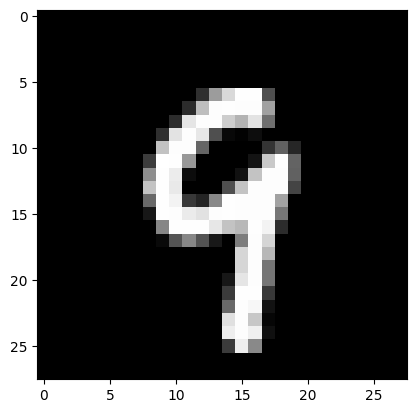

tensor(9)


In [10]:
import matplotlib.pyplot as plt
img = X_batch[1].reshape(28,28)
plt.imshow(img, cmap='gray')
plt.show()
print(y_batch[1])

In [11]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**Model FC NN**

In [12]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.drop_out = torch.nn.Dropout()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.drop_out(x)
        x = self.fc2(x)
        return x

n_hidden_neurons = 100
mnist_net = MNISTNet(n_hidden_neurons).to(device)

In [13]:
mnist_net

MNISTNet(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (ac1): Sigmoid()
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

**Loss function**

In [14]:
loss = torch.nn.CrossEntropyLoss()

**Optimizer**

In [15]:
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=learning_rate)

**Training procedure**

In [16]:
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in tqdm(range(num_epochs)):   # цикл обучения по эпохам

    running_loss_train = 0.
    running_acc_train = 0.
    for batch in train_dataloader_MNIST:# цикл обучения по бачам
        mnist_net.train()
        optimizer.zero_grad()
        X_batch, y_batch = batch

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_preds = mnist_net.forward(X_batch)

        # loss функция
        loss_train = loss(y_preds, y_batch)

        loss_train.backward()
        optimizer.step()
        running_loss_train += loss_train.cpu().detach().numpy()
        running_acc_train += (y_preds.argmax(dim=1) == y_batch).float().mean().cpu().detach().numpy()
    epoch_loss = running_loss_train/ len(train_dataloader_MNIST)
    train_loss_history.append(epoch_loss)

    epoch_acc = running_acc_train/len(train_dataloader_MNIST)
    train_accuracy_history .append(epoch_acc)

    running_loss_test = 0.
    running_acc_test = 0.
    # тестирование модели
    for batch in test_dataloader_MNIST:
        mnist_net.eval()
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_preds = mnist_net.forward(X_batch)

        running_loss_test += loss(y_preds, y_batch).cpu().detach().numpy()
        running_acc_test += (y_preds.argmax(dim=1) == y_batch).float().mean().cpu().detach().numpy()

    epoch_loss = running_loss_test/ len(test_dataloader_MNIST)
    test_loss_history.append(epoch_loss)

    epoch_acc = running_acc_test/ len(test_dataloader_MNIST)
    test_accuracy_history .append(epoch_acc)


100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


**Result test**

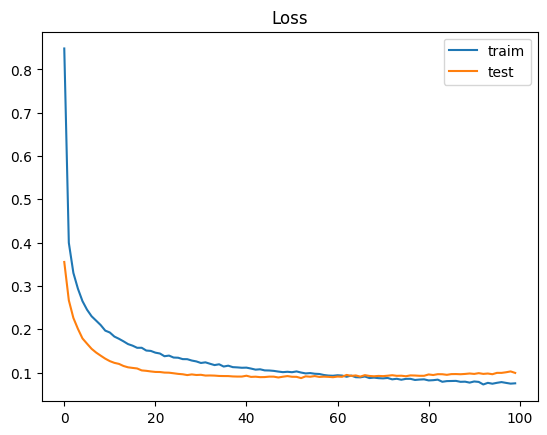

In [17]:
plt.plot(train_loss_history, label='traim')
plt.plot(test_loss_history, label='test')
plt.legend(loc='best')
plt.title('Loss');

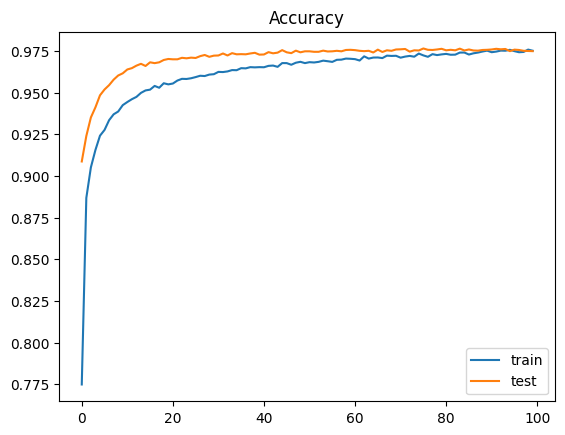

In [18]:
plt.plot(train_accuracy_history, label='train')
plt.plot(test_accuracy_history, label='test')
plt.legend(loc='best')
plt.title('Accuracy');

In [20]:
# Save the model state
st = mnist_net.state_dict()
torch.save(st, 'mnist_net.tar')
# torch.save(st, 'mnist_net.pth')

In [ ]:
# mnist_net.fc1.weight.data, mnist_net.fc1.bias.data